Summary Statistics:
                  GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000       0.000000   
25%         

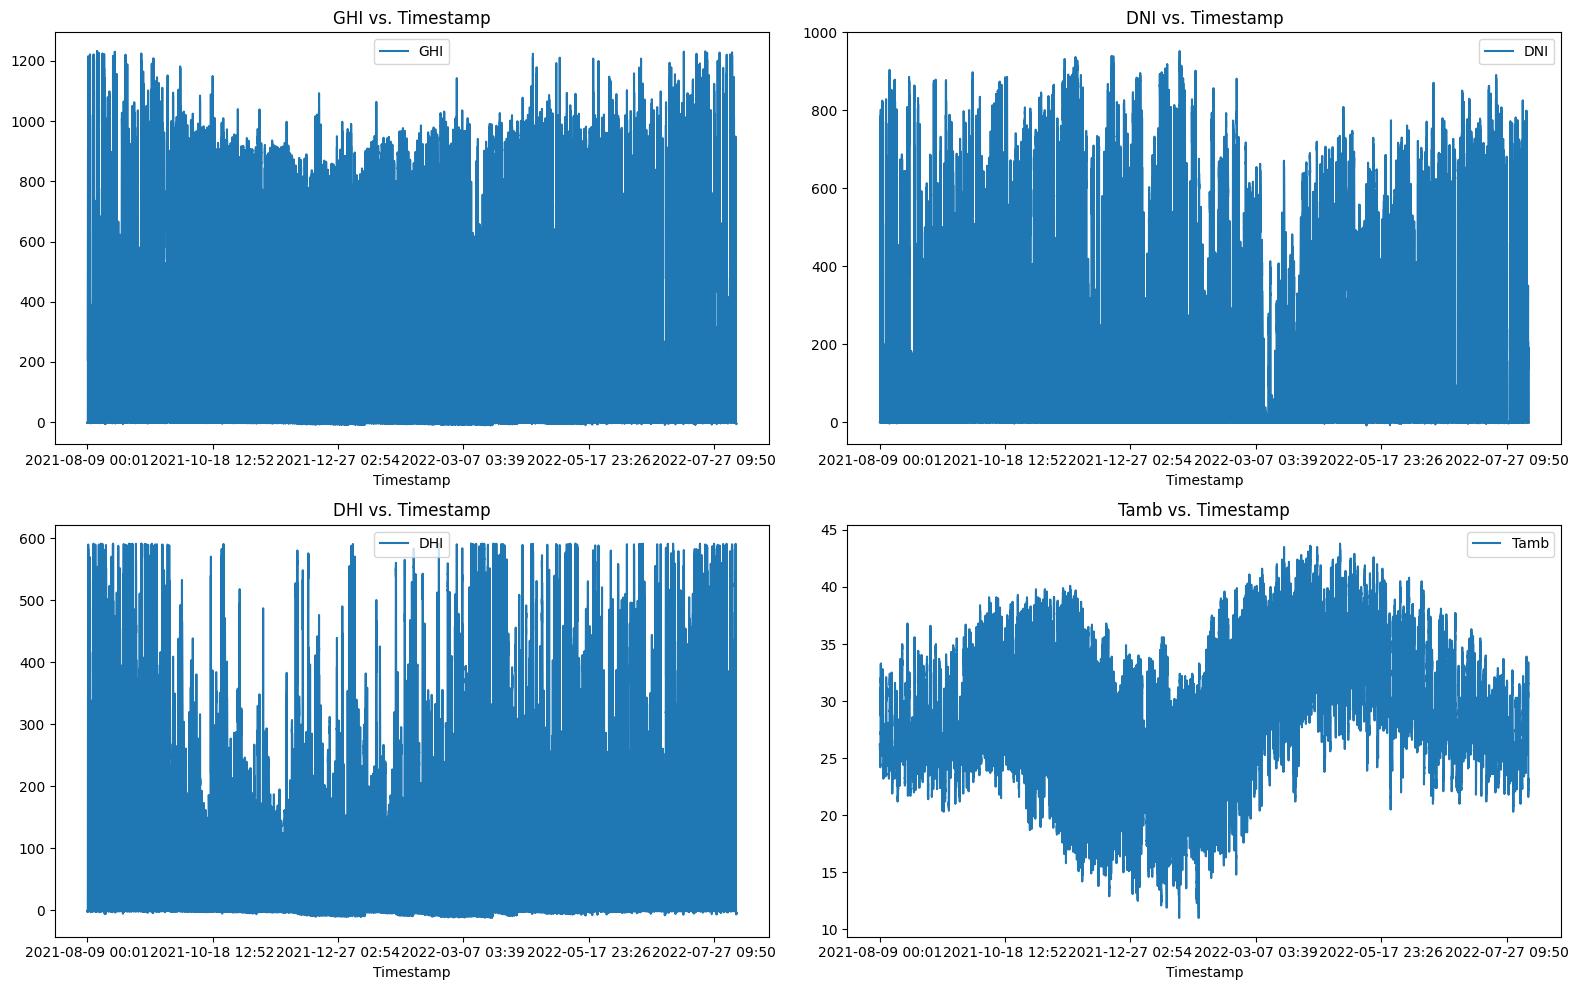

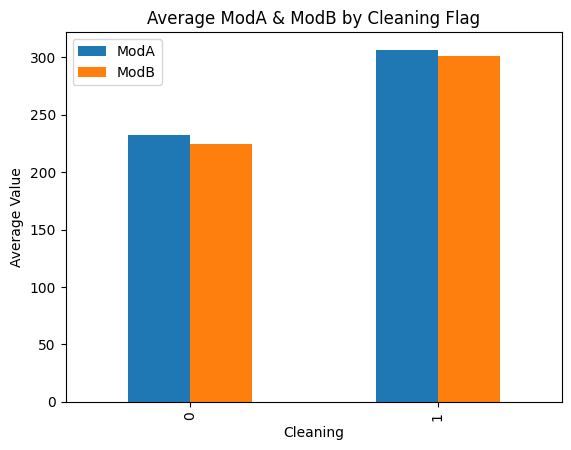

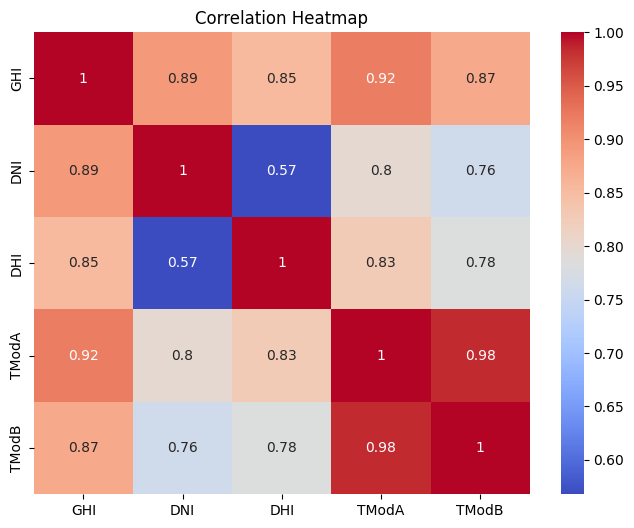

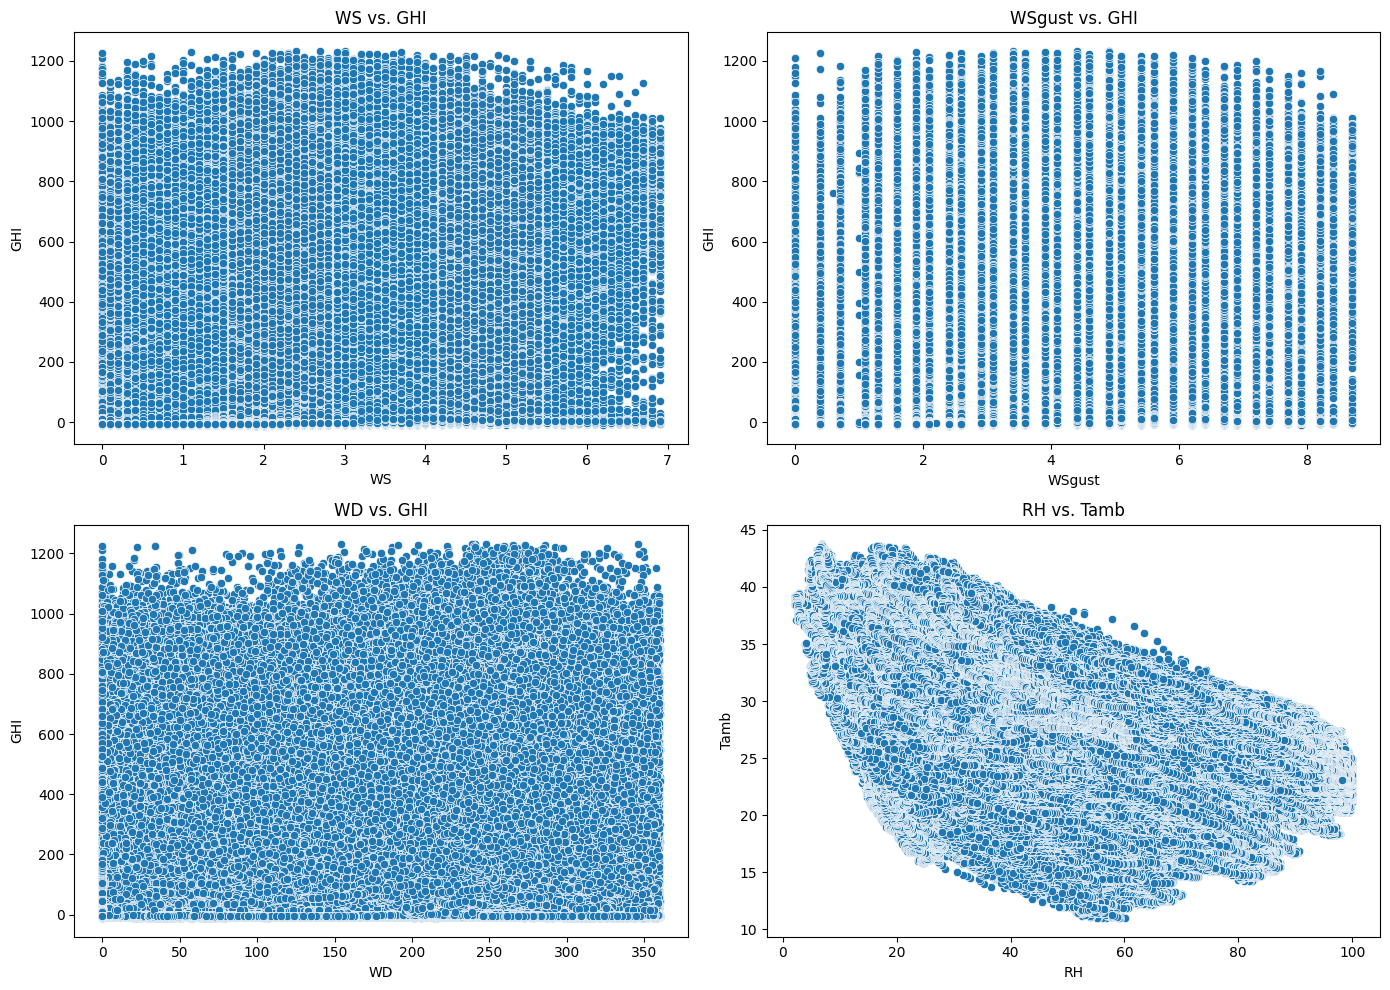

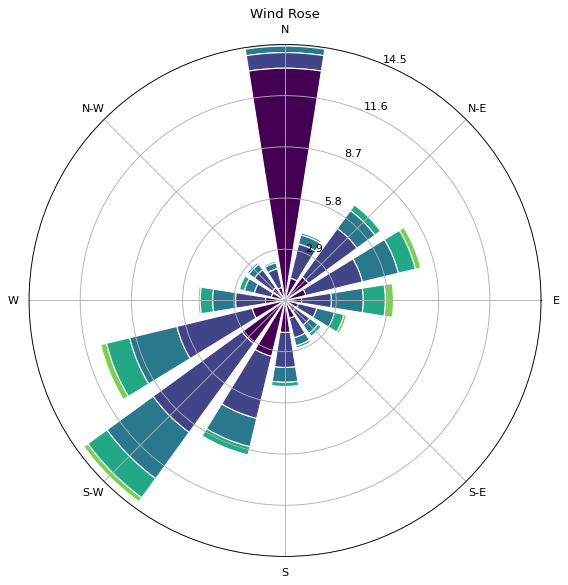

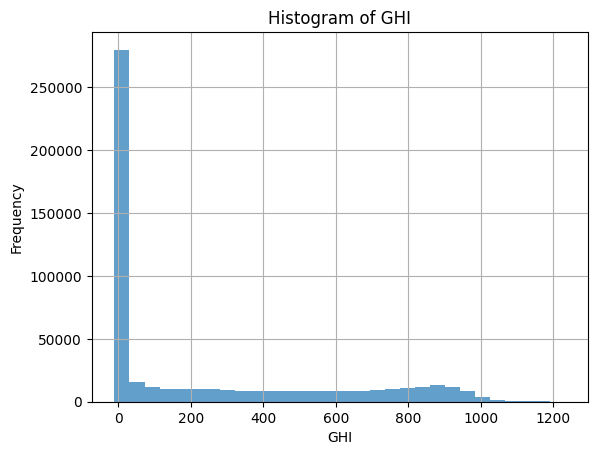

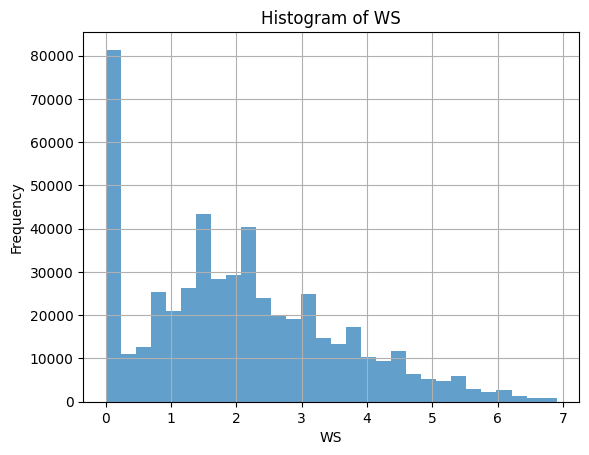

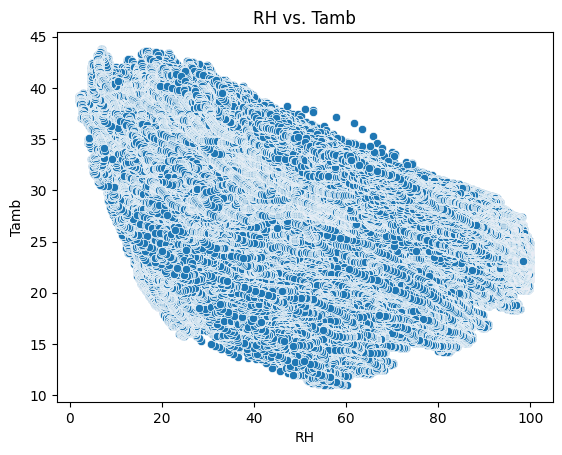

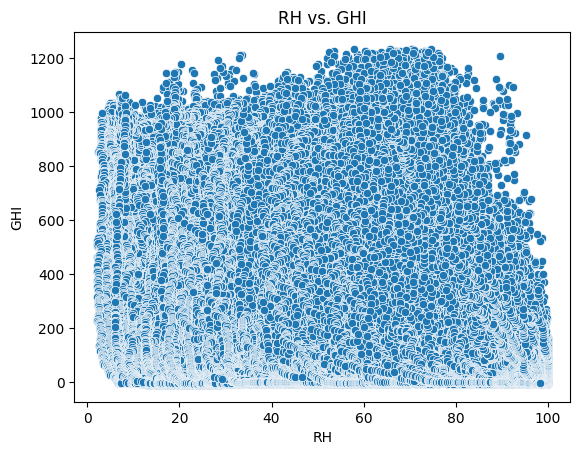

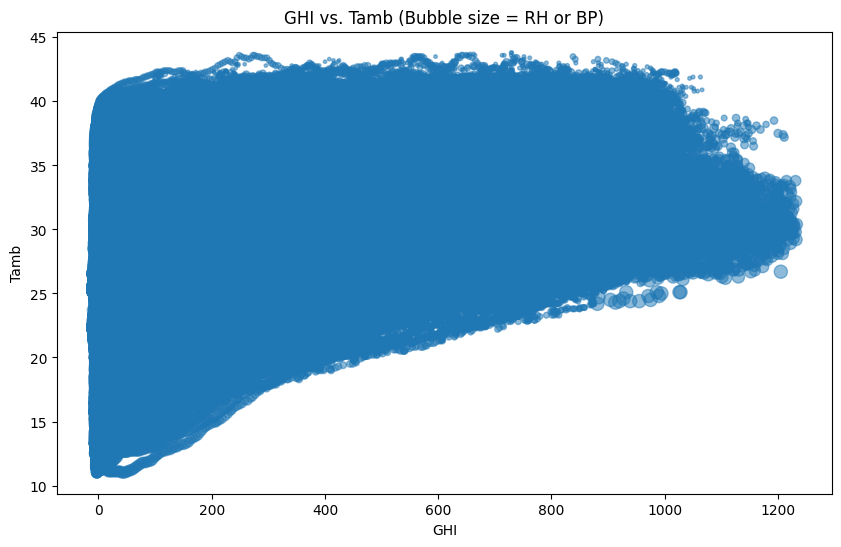

In [ ]:
# Exploratory Data Analysis (EDA) for Solar/Wind Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Load your data into df
# Summary Statistics & Missing-Value Report

df = pd.read_csv('../data/benin-malanville.csv', parse_dates=['Timestamp'])

summary_stats = df.describe()
missing_report = df.isna().sum()
n_rows = len(df)
missing_pct = (missing_report / n_rows) * 100
cols_gt5pct_nulls = missing_pct[missing_pct > 5].index.tolist()

print("Summary Statistics:\n", summary_stats)
print("\nMissing Value Report:\n", missing_report)
print("\nColumns with >5% missing values:", cols_gt5pct_nulls)

# Outlier Detection & Basic Cleaning
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
df_z = df[key_cols].apply(stats.zscore)
outlier_mask = (np.abs(df_z) > 3).any(axis=1)
print(f"\nNumber of outlier rows (|Z|>3): {outlier_mask.sum()}")

# Impute missing values in key columns with median
for col in key_cols:
    if df[col].isna().any():
        df[col].fillna(df[col].median(), inplace=True)

# Drop rows with outliers in key columns
df_clean = df[~outlier_mask].copy()

# Export cleaned DataFrame  # Replace with actual country name
df_clean.to_csv(f"../data/benin_clean.csv", index=False)

# Time Series Analysis
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
df_clean.plot(x='Timestamp', y='GHI', ax=axs[0,0], title='GHI vs. Timestamp')
df_clean.plot(x='Timestamp', y='DNI', ax=axs[0,1], title='DNI vs. Timestamp')
df_clean.plot(x='Timestamp', y='DHI', ax=axs[1,0], title='DHI vs. Timestamp')
df_clean.plot(x='Timestamp', y='Tamb', ax=axs[1,1], title='Tamb vs. Timestamp')
plt.tight_layout()
plt.show()

# Cleaning Impact
if 'Cleaning' in df_clean.columns:
    cleaning_group = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean()
    cleaning_group.plot(kind='bar', title='Average ModA & ModB by Cleaning Flag')
    plt.ylabel('Average Value')
    plt.show()

# Correlation & Relationship Analysis
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
plt.figure(figsize=(8,6))
sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Scatter plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(data=df_clean, x='WS', y='GHI', ax=axs[0,0])
axs[0,0].set_title('WS vs. GHI')
sns.scatterplot(data=df_clean, x='WSgust', y='GHI', ax=axs[0,1])
axs[0,1].set_title('WSgust vs. GHI')
sns.scatterplot(data=df_clean, x='WD', y='GHI', ax=axs[1,0])
axs[1,0].set_title('WD vs. GHI')
sns.scatterplot(data=df_clean, x='RH', y='Tamb', ax=axs[1,1])
axs[1,1].set_title('RH vs. Tamb')
plt.tight_layout()
plt.show()

# Wind Rose / Radial Bar Plot

from windrose import WindroseAxes

try:
    ax = WindroseAxes.from_ax()
    ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
    ax.set_title('Wind Rose')
    plt.show()
except Exception as e:
    print("Error plotting wind rose:", e)
    print("Ensure the windrose package is installed.")

# Histograms
df_clean['GHI'].hist(bins=30, alpha=0.7)
plt.title('Histogram of GHI')
plt.xlabel('GHI')
plt.ylabel('Frequency')
plt.show()

df_clean['WS'].hist(bins=30, alpha=0.7)
plt.title('Histogram of WS')
plt.xlabel('WS')
plt.ylabel('Frequency')
plt.show()

# Temperature Analysis: RH vs. Tamb and RH vs. GHI
sns.scatterplot(data=df_clean, x='RH', y='Tamb')
plt.title('RH vs. Tamb')
plt.show()

sns.scatterplot(data=df_clean, x='RH', y='GHI')
plt.title('RH vs. GHI')
plt.show()

# Bubble Chart: GHI vs. Tamb, bubble size = RH or BP
plt.figure(figsize=(10,6))
bubble_size = df_clean['RH'] if 'RH' in df_clean.columns else df_clean['BP']
plt.scatter(df_clean['GHI'], df_clean['Tamb'], s=bubble_size, alpha=0.5)
plt.xlabel('GHI')
plt.ylabel('Tamb')
plt.title('GHI vs. Tamb (Bubble size = RH or BP)')
plt.show()
